In [1]:
import Tasmanian as ts
import numpy as np
import scipy.optimize as opt
import sys
sys.path.append("..")
from src.py.option import AsianOption


In [2]:
def make_grid(dim, exactness, lb, rb, rule):
    """Creates a sparse grid according to given rules and boundaries.

    Args:
        dim (int): Input Dimension.
        exactness (int): Exactness of the integration.
        lb (array-like): Left boundary. Shape (dim) is recommended.
        rb (array-like): Right boundary. Shape (dim) is recommended.
        rule (str):  One of the local polynomial rules in TASMANIAN docs.
            Defaults to "localp".

    Returns:
        TasmanianSparseGrid: SparseGrid object.
    """
    grid = ts.makeGlobalGrid(
        dim, 1, exactness, "level", rule
    )
    grid.setDomainTransform(np.vstack([lb, rb]).T)
    return grid

aop = AsianOption(d=2)
# iNumInputs = 4
# iNumOutputs = 1
# grid = ts.SparseGrid()
# grid.makeLocalPolynomialGrid(iNumInputs, iNumOutputs, 4, iOrder=1, sRule="localp")


In [3]:
s_0_l=80.0
s_0_r=120.0
sigma_l=0.1
sigma_r=0.2
mu_l=0.02
mu_r=0.05
T_l=0.9
T_r=1.0

transform = np.array(
    [[s_0_l, s_0_r],
    [sigma_l, sigma_r],
    [mu_l, mu_r],
    [T_l, T_r]
    ]
)

In [31]:
dim, level = 2, 5
lb, rb =  np.zeros(dim), np.ones(dim)
grid = make_grid(dim, level, lb, rb, "gauss-patterson")
points = grid.getPoints()


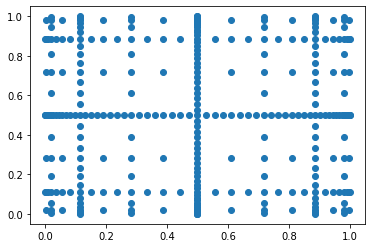

In [32]:
import matplotlib.pyplot as plt

plt.scatter(points[:, 0], points[:, 1])
plt.show()
# 3d plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# plt.show()

## Slice Arrays for smoothing

In [33]:
# ar = points[points[:, :-1].argsort(axis=0)[:, 0]]
hyperplanes, indices = np.unique(points[:, :-1], axis=0, return_index=True)

grid_slices = np.split(points, sorted(indices)[1:], axis=0)


In [34]:
# def cumargmax(a):
#     m = np.maximum.accumulate(a)
#     x = np.repeat(np.arange(a.shape[0])[:, None], a.shape[1], axis=1)
#     x[1:] *= m[:-1] < m[1:]
#     np.maximum.accumulate(x, axis=0, out=x)
#     return x[:, -1]

# partitions = np.unique(cumargmax(ar))
# grid_slices = np.split(ar, partitions[1:], axis=0)

In [35]:
# fig, axes = plt.subplots(nrows=5, ncols=4,sharex=True, sharey=True, figsize=(10,10))
# axes = np.ravel(axes)
# for i in range(len(grid_slices)):
#     x, y  = grid_slices[i][:, 0], grid_slices[i][:, 1]
#     axes[i].scatter(x,y)
# plt.show()


In [138]:
# Nullstellen findung vektorisieren!!!

def payout_coordinate_split(hyperplane, line):
    return aop.payout_func_opt(np.hstack([hyperplane, line]))

def fprime(x):
    return aop.payout_func_opt_der(x, coordinate=-1)


def find_hyperplane_root(plane, method, x0=0.999):
    foo = lambda x: aop.payout_func_opt(np.hstack([plane, x]))
    foo_fprime = lambda x: fprime(np.hstack([plane, x]))
    if method == "bisect":
        sol = opt.root_scalar(foo, x0=x0, bracket=[1, 0], method=method)
    elif method == "newton":
        sol = opt.root_scalar(foo, x0=x0, fprime=foo_fprime, method=method)
    return sol.root
x0 = 0.99
ar_roots = np.apply_along_axis(find_hyperplane_root, axis=1, arr=hyperplanes, method="newton", x0=x0)


In [139]:
ar_roots

array([0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.9835162 , 0.97379558, 0.96033912,
       0.94249191, 0.91970668, 0.89159862, 0.85798998, 0.8189399 ,
       0.7747564 , 0.72598939, 0.6734057 , 0.61794848, 0.5606849 ,
       0.50274687, 0.4452696 , 0.38906092, 0.3354943 , 0.28549695,
       0.23966006, 0.18809635, 0.12889081, 0.07095305, 0.01484573,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

In [140]:
transformed_slices = list()
for slice, zero in zip(grid_slices, ar_roots):
    if np.isnan(zero) or zero == x0:
        transformed_slices.append(slice)
    else:
        transformed_slices.append(slice*(1-zero)+zero)

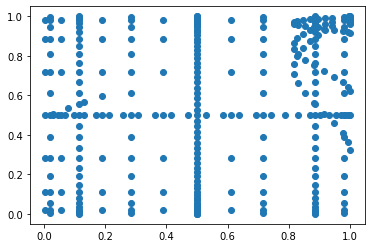

In [141]:
transformed_points = np.concatenate(transformed_slices)


plt.scatter(transformed_points[:, 0], transformed_points[:, 1])
plt.show()
# 3d plot
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2])
# plt.show()

In [142]:
np.inner(grid.getQuadratureWeights(), aop.payout_func_opt(points)), aop.scholes_call()

(9.914494443961734, 9.927486225229053)

In [143]:
np.inner(grid.getQuadratureWeights(), aop.payout_func_opt(transformed_points)), aop.scholes_call()

(17.461018455952907, 9.927486225229053)

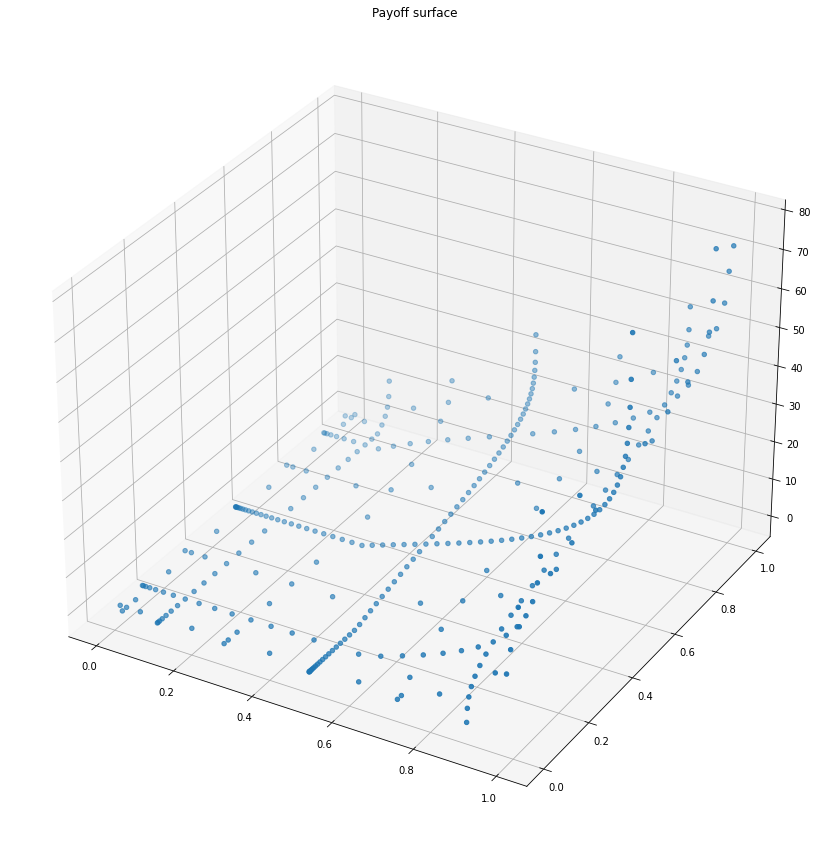

In [144]:
payoff = aop.payout_func_opt(points)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 0], points[:, 1], payoff)
ax.set_title("Payoff surface")
plt.show()

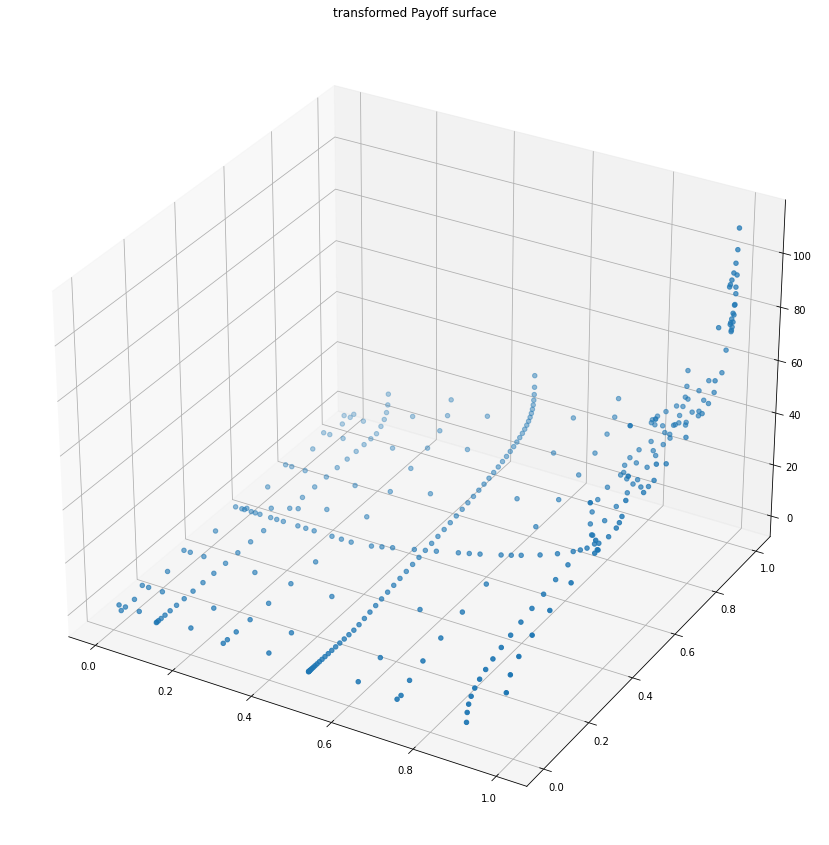

In [145]:
payoff = aop.payout_func_opt(transformed_points)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(transformed_points[:, 0], transformed_points[:, 1], payoff)
ax.set_title("transformed Payoff surface")
plt.show()